In [1]:
import binascii
import serial
import os
import numpy as np
from PIL import Image

os.system('sh ./stop_sys_ttyPS0.sh')

0

In [2]:
def red_ratio(img):
    W,H = img.size
    img = np.array(img)
    S = H * W
    # 计算红色像素色块所占比例
#     mask  = img[:,:,0]>100
#     print(mask)
    img_red = np.sum((img[:,:,0]>100) & (img[:,:,1]<100) & (img[:,:,2]<100))
    
    return img_red / S

# 判断图像中红色色块的左右位置，输出具体的关于中垂线相对位置
def red_side(img):
    W,H = img.size
    img = np.array(img)
    L = np.arange(W) - W/2
    L = np.expand_dims(L,axis=0)
    M = np.repeat(L,H,axis=0) / H #归一化
    mask  = (img[:,:,0]>100) & (img[:,:,1]<100) & (img[:,:,2]<100)
    # 生成只有红色色块X坐标的矩阵
    M = M[mask]
    # 找到红色色块的平均中心X坐标
    center = np.sum(M) / np.sum(mask)
    # 返回中心X坐标
    return center

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
0.00416015625
0.0626842070944


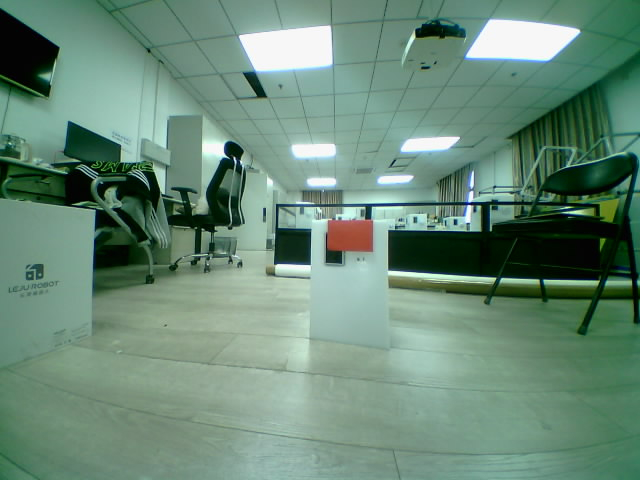

In [3]:
orig_img_path = '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'
# !fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2> /dev/null
!fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2

img = Image.open(orig_img_path)
print(red_ratio(img))
print(red_side(img))
img

In [7]:
import os

def updateImage():
    orig_img_path = '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'
#     os.system("fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2")
    !fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2
    img = Image.open(orig_img_path)
    return img

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.


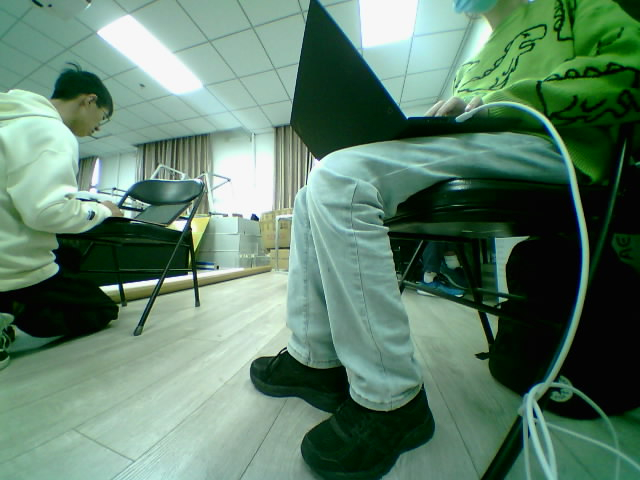

In [43]:
img = updateImage()
img

In [4]:
def run_action(cmd):
    ser = serial.Serial("/dev/ttyPS0", 9600, timeout=5)
    cnt_err = 0
    while 1:
        test_read = ser.read()
        print('test_read', test_read)
        cnt_err += 1
        if test_read== b'\xa3' or cnt_err == 50:
            break
    
    if cnt_err == 50:
        print('can not get REQ')
    else:
        print('read REQ finished!')
        ser.write(cmd2data(cmd))
        print('send action ok!')
    ser.close()
    
def crc_calculate(package):
    crc = 0
    for hex_data in package:

        b2 = hex_data.to_bytes(1, byteorder='little')
        crc = binascii.crc_hqx(b2, crc)

    return [(crc >> 8), (crc & 255)]    # 校验位两位

def cmd2data(cmd):
    cnt=0
    cmd_list=[]
    for i in cmd:
        cnt+=1
        cmd_list+=[ord(i)]
    cmd_list=[0xff,0xff]+[(cnt+5)>>8,(cnt+5)&255]+[0x01,(cnt+1)&255,0x03]+cmd_list
    cmd_list=cmd_list+crc_calculate(cmd_list)
    return cmd_list

def wait_req():
    ser = serial.Serial("/dev/ttyPS0", 9600, timeout=5)
    while 1:
        test_read=ser.read()
        if test_read== b'\xa3' :
            print('read REQ finished!') 
            break

In [9]:
img = updateImage()
# img
threshold_red_begin = 0.014 # 开始避障的红色阈值
threshold_red_safe = 0.40 # 安全状态下的红色平均X坐标绝对值最小值
left_right = 0 # 记录过程中的偏移量,这样可以之后恢复直线,右为+,左为-
flag = False # 是否经历过避障的过程
print(red_ratio(img))


--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
0.00402994791667


In [11]:
while(True):
    img = updateImage() # 更新图像
    offset = red_side(img)
    print(f'Red Ratio: {red_ratio(img)}')
    print(f'Offset: {offset}')
    
    if (red_ratio(img) >= threshold_red_begin) and (abs(offset)<=threshold_red_safe):
        print("到了临界区了！！！")
        flag = True
#         while(abs(offset)<=threshold_red_safe):
        if offset > 0: # 对方红色在右侧,应当左移
            run_action('Left3move')
            wait_req()
            run_action('Left3move')
            left_right -= 1
        else:         # 对方红色在左侧,应当右移
            run_action('Right3move')
            wait_req()
            run_action('Right3move')
            left_right += 1
#             img = updateImage()
#             offset = red_side(img) # 偏移量坐标
    else: #(red_ratio(img)<threshold_red_begin):
            print("运动了！！！")
            run_action('Forwalk02')
            wait_req()
            run_action('turn003L')


# # 恢复直线
# while(left_right != 0):
#     if left_right < 0: # 左移过多,应当向右
#         run_action('turn010R')
#         run_action('Forwalk02')
#         left_right += 1
#     else:
#         run_action('turn010L')
#         run_action('Forwalk02')
#         left_right -= 1

# 向前走一段距离
forward = 10
for i in range(forward):
    run_action('Forwalk02')

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Red Ratio: 0.005052083333333333
Offset: 0.09324795962199313
运动了！！！
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
read REQ finished!
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_r

read REQ finished!
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG 

/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
read REQ finished!
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
--- Opening /dev/video0...
Trying source module

KeyboardInterrupt: 

In [ ]:
run_action('Forwalk02')
wait_req()

test_read b''
test_read b''
test_read b''
test_read b''
